# Clinical Trial Matching Evaluation

This notebook evaluates an AI model's performance in matching patients to relevant clinical trials, analyzing the effectiveness of patient-trial eligibility predictions against gold standard judgments.

## Contents and Key Findings

1. **Data Processing Pipeline**:
   - Loads gold standard patient-trial pairs with relevance labels (0-2)
   - Processes model predictions with detailed reasoning for inclusion/exclusion decisions
   - Merges datasets to enable direct comparison between predictions and ground truth

2. **Evaluation Framework**:
   - Maps predictions to a 4-point scale: 
     - 0: Would not refer
     - 1: Would consider referral
     - 2: Highly likely to refer
     - 3: Not captured (cases not evaluated by model)
   - Calculates performance metrics excluding "Not captured" cases
   - Generates confusion matrices to visualize prediction patterns

3. **Performance Analysis**:
   - Detailed classification report showing precision, recall, and F1 score per class
   - Investigation of specific cases, including false negatives and true positives
   - Identification of patterns in model reasoning for both correct and incorrect predictions

4. **Threshold Optimization**:
   - Grid search approach to find optimal score cutpoints for classification
   - Separate optimization targets for overall performance (macro F1) and class-specific F1 scores
   - Visualizations of prediction distribution under different threshold settings

The analysis reveals both strengths and limitations in the current matching system, with the threshold optimization showing potential to improve performance by fine-tuning classification boundaries. The detailed examination of specific cases provides actionable insights for model improvement, particularly for reducing false negatives in high-priority matches.

This evaluation methodology combines quantitative metrics with qualitative analysis of prediction rationales, offering a comprehensive assessment of the clinical trial matching system's practical utility.

# --- Section 1: Imports and Configuration ---

In [1]:
import os
import glob
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Configure pandas display settings for better readability in notebook
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 80)

# List directory contents using shell command
# ll ../data/sigir2016/old/matched

# --- Section 2: Data Loading and Path Configuration ---

In [2]:
# Define paths to data directories and files
DATA_DIR = "../data/sigir2016/processed_cut_debug"
MATCHED_DIR = "../run/matched" #"../data/sigir2016/matched"

TSV_FILE = os.path.join(DATA_DIR, "test.tsv")
QUERIES_FILE = os.path.join(DATA_DIR, "queries.jsonl")
CORPUS_FILE = os.path.join(DATA_DIR, "corpus.jsonl")
TRIAL_MATCHES_FILE = os.path.join(MATCHED_DIR, "trial_matches.json")

# Load the three primary datasets:
# - TSV file: Contains gold standard patient-trial pairs with relevance scores
# - Queries: Patient data (each patient is a query)
# - Corpus: Clinical trial data (each trial is a document in the corpus)
df_tsv = pd.read_csv(TSV_FILE, sep='\t')
# Rename 'score' column to 'label' in the gold standard dataframe
df_tsv = df_tsv.rename(columns={'score': 'label'})
df_queries = pd.read_json(QUERIES_FILE, lines=True)
df_corpus = pd.read_json(CORPUS_FILE, lines=True)

# Display dataset sizes to verify loading
print(f" df_tsv {len(df_tsv)} df_queries {len(df_queries)} df_corpus {len(df_corpus)}")

# Preview the loaded datasets
display(df_tsv.head())
display(df_queries.head())
display(df_corpus.head())

 df_tsv 12 df_queries 4 df_corpus 12


,query-id,corpus-id,label
0,sigir-20141,NCT00000408,0
1,sigir-20141,NCT00000492,1
2,sigir-20141,NCT00005127,2
3,sigir-201410,NCT00043277,0
4,sigir-201410,NCT00533156,1


,_id,text
0,sigir-20141,A 58-year-old African-American woman presents to the ER with episodic pressi...
1,sigir-201410,A physician is called to see a 67-year-old woman who underwent cardiac cathe...
2,sigir-201411,A 40-year-old woman with no past medical history presents to the ER with exc...
3,sigir-201412,A 25-year-old woman presents to the clinic complaining of prolonged fatigue....


,_id,title,metadata
0,NCT00000408,Low Back Pain Patient Education Evaluation,"{'phase': 'N/A', 'drugs': '['Patient education evaluation']', 'drugs_list': ..."
1,NCT00000492,Beta-Blocker Heart Attack Trial (BHAT),"{'phase': 'Phase 3', 'drugs': '['propranolol']', 'drugs_list': ['propranolol..."
2,NCT00005127,Muscatine Heart Study,"{'phase': 'N/A', 'drugs': '[]', 'drugs_list': [], 'diseases_list': ['Cardiov..."
3,NCT00011102,Prevention of Weight Gain,"{'phase': 'N/A', 'drugs': '['Weight Gain Prevention for Women Project']', 'd..."
4,NCT00043277,Study Of Angiomax In Infants Under Six Months With Thrombosis,"{'phase': 'Phase 2', 'drugs': '['Angiomax (bivalirudin)']', 'drugs_list': ['..."


# --- Section 3: Loading and Flattening Trial Matches Data ---

In [3]:
TRIAL_MATCHES_FILE = os.path.join(MATCHED_DIR, "trial_matches.json")

# Load the model's prediction results from JSON
with open(TRIAL_MATCHES_FILE, "r") as f:
    trial_matches = json.load(f)

# Flatten the nested JSON structure into a list of records
# Each record represents a patient-trial evaluation with detailed matching results
records = []
for patient_dict in trial_matches:
    patient_id = patient_dict['patient_id']
    for eval_ in patient_dict['trial_evaluations']:
        trial_id = eval_['trial_id']
        trial_title = eval_.get('trial_title')
        scoring = eval_.get('scoring_result', {})
        inclusion = eval_.get('inclusion_result', {})
        exclusion = eval_.get('exclusion_result', {})
        records.append({
            'query-id': patient_id,
            'corpus-id': trial_id,
            'trial_title': trial_title,
            # From scoring_result - overall match scoring
            'score': scoring.get('score'),
            'match_verdict': scoring.get('verdict'),
            'match_reasoning': scoring.get('reasoning'),
            # From exclusion_result - reasons patient might be excluded
            'exclusion_verdict': exclusion.get('verdict'),
            'exclusion_reason': exclusion.get('reason'),
            # From inclusion_result - inclusion criteria evaluation
            'inclusion_verdict': inclusion.get('verdict'),
            'inclusion_missing_info': inclusion.get('missing_information'),
            'inclusion_unmet_criteria': inclusion.get('unmet_criteria'),
            'inclusion_reasoning': inclusion.get('reasoning'),
        })

# Convert to DataFrame for easier manipulation
df_trial_matches = pd.DataFrame(records)

# Display number of evaluations processed
len(df_trial_matches)

48

# --- Section 4: Merging and Preprocessing Data ---

In [4]:
# Merge gold standard data (df_tsv) with model predictions (df_trial_matches)
# Using left join to keep all gold standard pairs, even if model didn't evaluate them
merged_df = df_tsv.merge(df_trial_matches, on=['query-id', 'corpus-id'], how='left')

# 1. Add patient information from queries dataset
merged_df = merged_df.merge(
    df_queries.rename(columns={'_id': 'query-id'}),
    on='query-id',
    how='left'
)

# 2. Add trial information from corpus dataset
merged_df = merged_df.merge(
    df_corpus.rename(columns={'_id': 'corpus-id'}),
    on='corpus-id',
    how='left'
)
# Remove redundant title column
merged_df = merged_df.drop(columns=['title'])

# Check possible match verdict values
(merged_df['match_verdict']).unique()

array([None, 'WOULD NOT REFER', 'HIGHLY LIKELY TO REFER',
       'WOULD CONSIDER REFERRAL'], dtype=object)

# --- Section 5: Handling Missing Values and Label Encoding ---

In [5]:
# Handle missing verdicts:
# - If all verdicts are missing, the pair was not evaluated by the model
# - If exclusion/inclusion verdicts exist but overall verdict is missing, treat as "WOULD NOT REFER"
def maybe_not_captured(row):
    if pd.isna(row['match_verdict']) and pd.isna(row['exclusion_verdict']) and pd.isna(row['inclusion_verdict']):
        return "Not captured"  # genuinely not evaluated
    if pd.isna(row['match_verdict']):
        return "WOULD NOT REFER"  # evaluated, but no overall verdict (treat as 0)
    return row['match_verdict']

merged_df['match_verdict'] = merged_df.apply(maybe_not_captured, axis=1)

# Fix missing scores:
# If a verdict exists but score is missing, set score to 0
def fix_score(row):
    # If either verdict is present, set to 0 (evaluated, but no score)
    if pd.notna(row['exclusion_verdict']) or pd.notna(row['inclusion_verdict']):
        return "0"
    # If both are missing, leave as NaN
    return np.nan

# Apply score fix only to rows where 'score' is null
mask = merged_df['score'].isna()
merged_df.loc[mask, 'score'] = merged_df[mask].apply(fix_score, axis=1)

# Map text verdicts to numeric labels for evaluation:
# 2 = Highly likely to refer
# 1 = Would consider referral
# 0 = Would not refer
# 3 = Not captured (special case for pairs not evaluated by model)
verdict_map = {
    "HIGHLY LIKELY TO REFER": 2,
    "WOULD CONSIDER REFERRAL": 1,
    "WOULD NOT REFER": 0,
    "Not captured": 3
}
merged_df['predicted_label'] = merged_df['match_verdict'].map(verdict_map).astype(int)

# Preview the merged and processed dataset
display(merged_df)

,query-id,corpus-id,label,trial_title,score,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,text,metadata,predicted_label
0,sigir-20141,NCT00000408,0,Low Back Pain Patient Education Evaluation,0,WOULD NOT REFER,None,PASS,Patient does not meet any exclusion criteria. The patient's information does...,FAIL,None,- Must have seen a doctor for back pain at least once in the past year (the ...,The patient's chief complaint is episodic pressing/burning anterior chest pa...,A 58-year-old African-American woman presents to the ER with episodic pressi...,"{'phase': 'N/A', 'drugs': '['Patient education evaluation']', 'drugs_list': ...",0
1,sigir-20141,NCT00000492,1,Beta-Blocker Heart Attack Trial (BHAT),2,WOULD NOT REFER,The patient's chief complaint of episodic pressing/burning anterior chest pa...,PASS,No exclusion criteria specified,UNDETERMINED,N/A,N/A,No inclusion criteria specified,A 58-year-old African-American woman presents to the ER with episodic pressi...,"{'phase': 'Phase 3', 'drugs': '['propranolol']', 'drugs_list': ['propranolol...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,sigir-201412,NCT00271427,2,Selenium Treatment in Autoimmune Thyroiditis (AIT),5,WOULD CONSIDER REFERRAL,"The patient presents with symptoms highly suggestive of hypothyroidism, such...",PASS,Patient does not meet any exclusion criteria. There is no mention of drug us...,UNDETERMINED,* Current TSH levels and whether they are in the lower half of the normal ra...,None,"The patient presents with symptoms suggestive of hypothyroidism, such as hai...",A 25-year-old woman presents to the clinic complaining of prolonged fatigue....,"{'phase': 'N/A', 'drugs': '['L-Selenomethionine']', 'drugs_list': ['L-Seleno...",1
11,sigir-201412,NCT00360074,1,Phase 4 Study in Secondary Hypothyroidism: Body Weight Adapted Thyroxin Trea...,5,WOULD CONSIDER REFERRAL,"The patient presents with symptoms suggestive of hypothyroidism, such as hai...",PASS,Patient does not meet any exclusion criteria. The patient's symptoms and fin...,UNDETERMINED,- Confirmation of hypopituitarism of at least 3 axes\n- History of surgical ...,None,"The patient presents with symptoms suggestive of hypopituitarism, such as ha...",A 25-year-old woman presents to the clinic complaining of prolonged fatigue....,"{'phase': 'Phase 4', 'drugs': '['Thyroxin, Triiodothyronine']', 'drugs_list'...",1


# --- Section 6: Evaluation and Confusion Matrix ---

In [6]:
# Extract ground truth labels and predictions
y_true = merged_df['label'].astype(int)  # Gold standard labels
y_pred = merged_df['predicted_label'].astype(int)  # Model predictions

# Define label sets and readable names
labels_true = [0, 1, 2]  # Gold standard only has 3 classes
labels_pred = [0, 1, 2, 3]  # Predictions have a 4th class for "not captured"

label_names_true = [
    "0) Would not refer",
    "1) Would consider referral",
    "2) Highly likely to refer"
]
label_names_pred = [
    "0) Would not refer",
    "1) Would consider referral",
    "2) Highly likely to refer",
    "3) Not captured"
]

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels_pred)
cm = cm[:3, :]  # Only first 3 rows (since y_true only in {0,1,2})

# Display confusion matrix as a DataFrame for readability
cm_df = pd.DataFrame(
    cm,
    index=label_names_true,
    columns=label_names_pred
)

# --- Section 7: Calculate Metrics Excluding "Not Captured" Cases ---

 length df_tsv:12 length df_queries:4 length df_corpus:12



,0) Would not refer,1) Would consider referral,2) Highly likely to refer,3) Not captured
0) Would not refer,3,1,0,0
1) Would consider referral,2,2,0,0
2) Highly likely to refer,1,2,1,0



Macro F1 score (excluding "Not captured" predictions): 0.4815

Detailed classification report (excluding 'Not captured'):

                            precision    recall  f1-score   support

        0) Would not refer       0.50      0.75      0.60         4
1) Would consider referral       0.40      0.50      0.44         4
 2) Highly likely to refer       1.00      0.25      0.40         4

                  accuracy                           0.50        12
                 macro avg       0.63      0.50      0.48        12
              weighted avg       0.63      0.50      0.48        12



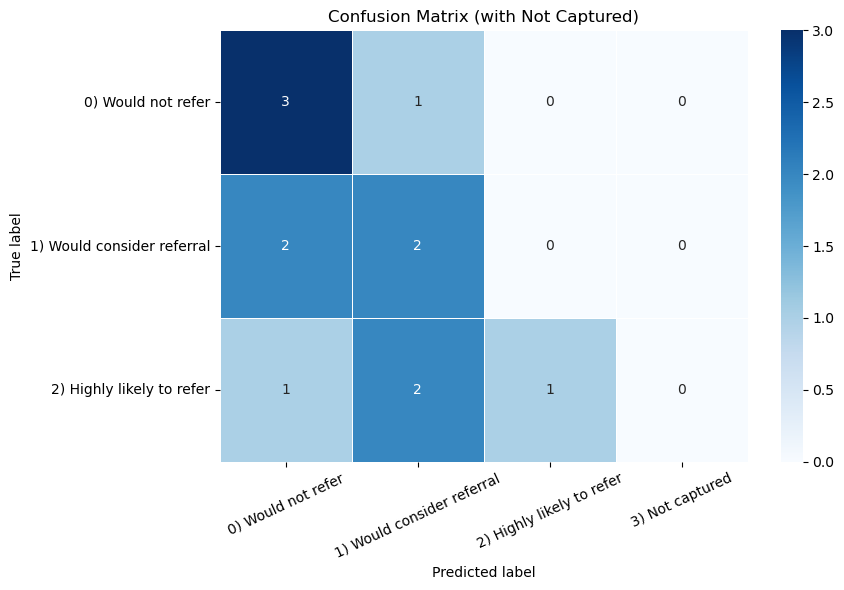

In [7]:
# Output dataset sizes for verification
print(f" length df_tsv:{len(df_tsv)} length df_queries:{len(df_queries)} length df_corpus:{len(df_corpus)}\n")
# Display confusion matrix
display(cm_df)
# Filter to only include evaluated pairs (excluding "Not captured")
mask_eval = y_pred.isin([0,1,2])
y_true_eval = y_true[mask_eval]
y_pred_eval = y_pred[mask_eval]

label_names = [
    "0) Would not refer",
    "1) Would consider referral",
    "2) Highly likely to refer"
]

# Calculate F1 score and classification report
f1 = f1_score(y_true_eval, y_pred_eval, labels=[0,1,2], average='macro')
print(f'\nMacro F1 score (excluding "Not captured" predictions): {f1:.4f}\n')

print("Detailed classification report (excluding 'Not captured'):\n")
print(classification_report(
    y_true_eval, y_pred_eval, labels=[0,1,2], target_names=label_names
))

# Visualize confusion matrix with heatmap
plt.figure(figsize=(9,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True,
            linewidths=.5, square=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (with Not Captured)')
plt.yticks(rotation=0)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

# --- Section 8: Detailed Analysis of Specific Prediction Cases ---

In [8]:
# Adjust display settings to show more rows
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

In [9]:
# Case 1: Analyze false negatives - should be "Highly likely" but predicted as "Would not refer"
df_true2_pred = merged_df[(merged_df["label"] == 2) & (merged_df["predicted_label"] == 0)]
display(df_true2_pred)
print(f"Rows: {len(df_true2_pred)}")

,query-id,corpus-id,label,trial_title,score,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,text,metadata,predicted_label
2,sigir-20141,NCT00005127,2,Muscatine Heart Study,2,WOULD NOT REFER,"The patient's chief complaint of episodic pressing/burning anterior chest pain, accompanied by n...",PASS,No exclusion criteria specified,UNDETERMINED,N/A,N/A,No inclusion criteria specified,A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior ...,"{'phase': 'N/A', 'drugs': '[]', 'drugs_list': [], 'diseases_list': ['Cardiovascular Diseases', '...",0


Rows: 1


In [10]:
# Case 2: Analyze true positives for "Highly likely to refer" class
df_true2_pred = merged_df[(merged_df["label"] == 2) & (merged_df["predicted_label"] == 2)]
display(df_true2_pred)
print(f"Rows: {len(df_true2_pred)}")

,query-id,corpus-id,label,trial_title,score,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,text,metadata,predicted_label
5,sigir-201410,NCT01599195,2,Use of Amplified Sound Signal to Identify Presence of Carotid and Femoral Stenosis,9,HIGHLY LIKELY TO REFER,"The patient's medical condition, characterized by a pulsatile mass in the right groin, loss of d...",PASS,"Patient does not meet any exclusion criteria. The patient's age is 67 years, which falls within ...",INCLUDE,None,None,"The patient's age is 67 years, which falls within the specified range of 19-90 years. The patien...",A physician is called to see a 67-year-old woman who underwent cardiac catheterization via the r...,"{'phase': 'N/A', 'drugs': '['AudioDoc']', 'drugs_list': ['AudioDoc'], 'diseases_list': ['Carotid...",2


Rows: 1


In [11]:
# Case 3: Analyze true positives for "Would consider referral" class
df_true1_pred = merged_df[(merged_df["label"] == 1) & (merged_df["predicted_label"] == 1)]
display(df_true1_pred)
print(f"Rows: {len(df_true1_pred)}")

,query-id,corpus-id,label,trial_title,score,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,text,metadata,predicted_label
7,sigir-201411,NCT00382421,1,Study to Investigate Effects of Antiischemic Drug Therapy in Silent Ischemia,4,WOULD CONSIDER REFERRAL,"The patient's presentation with excruciating pain in her right arm, tachycardic heart rate, tach...",PASS,Patient does not meet any exclusion criteria. The trial's exclusion criterion is a history of ca...,UNDETERMINED,- Documentation of silent myocardial ischemia type I\n- Presence of at least one cardiovascular ...,None,The clinical trial requires documented silent myocardial ischemia type I and at least one cardio...,A 40-year-old woman with no past medical history presents to the ER with excruciating pain in he...,"{'phase': 'N/A', 'drugs': '['bisoprolol', 'amlodipine', 'molsidomine', 'acetylsalicylic acid']',...",1
11,sigir-201412,NCT00360074,1,Phase 4 Study in Secondary Hypothyroidism: Body Weight Adapted Thyroxin Treatment and Triiodothy...,5,WOULD CONSIDER REFERRAL,"The patient presents with symptoms suggestive of hypothyroidism, such as hair loss, change in vo...",PASS,"Patient does not meet any exclusion criteria. The patient's symptoms and findings, such as hair ...",UNDETERMINED,- Confirmation of hypopituitarism of at least 3 axes\n- History of surgical or radiation treatme...,None,"The patient presents with symptoms suggestive of hypopituitarism, such as hair loss, change in v...",A 25-year-old woman presents to the clinic complaining of prolonged fatigue. She denies difficul...,"{'phase': 'Phase 4', 'drugs': '['Thyroxin, Triiodothyronine']', 'drugs_list': ['Thyroxin, Triiod...",1


Rows: 2


In [12]:
# Case 4: Analyze true positives for "Would not refer" class
df_true0_pred = merged_df[(merged_df["label"] == 0) & (merged_df["predicted_label"] == 0)]
display(df_true0_pred)
print(f"Rows: {len(df_true0_pred)}")

,query-id,corpus-id,label,trial_title,score,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,text,metadata,predicted_label
0,sigir-20141,NCT00000408,0,Low Back Pain Patient Education Evaluation,0,WOULD NOT REFER,None,PASS,Patient does not meet any exclusion criteria. The patient's information does not mention back pa...,FAIL,None,- Must have seen a doctor for back pain at least once in the past year (the patient's chief comp...,"The patient's chief complaint is episodic pressing/burning anterior chest pain, which does not a...",A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior ...,"{'phase': 'N/A', 'drugs': '['Patient education evaluation']', 'drugs_list': ['Patient education ...",0
3,sigir-201410,NCT00043277,0,Study Of Angiomax In Infants Under Six Months With Thrombosis,0,WOULD NOT REFER,None,EXCLUDE,"The patient has a recent cardiac catheterization via the right femoral artery, which suggests a ...",None,None,None,None,A physician is called to see a 67-year-old woman who underwent cardiac catheterization via the r...,"{'phase': 'Phase 2', 'drugs': '['Angiomax (bivalirudin)']', 'drugs_list': ['Angiomax (bivalirudi...",0
6,sigir-201411,NCT00243152,0,Evaluation of Lamotrigine on Neuropathic Facial Pain Using fMRI,0,WOULD NOT REFER,None,PASS,Patient does not meet any exclusion criteria. The patient's information does not indicate any si...,FAIL,None,- Diagnosed with facial pain: The patient's chief complaint is excruciating pain in her right ar...,The patient's chief complaint and duration of pain clearly do not align with the trial's inclusi...,A 40-year-old woman with no past medical history presents to the ER with excruciating pain in he...,"{'phase': 'N/A', 'drugs': '['Lamotrigine']', 'drugs_list': ['Lamotrigine'], 'diseases_list': ['F...",0


Rows: 3


# --- Section 9: Threshold Optimization ---


Best cutpoints for macro F1: cut1=1, cut2=6, F1=0.6722
Classification Report (excluding 'Not captured'):
                            precision    recall  f1-score   support

        0) Would not refer       0.75      0.75      0.75         4
1) Would consider referral       0.50      0.75      0.60         4
 2) Highly likely to refer       1.00      0.50      0.67         4

                  accuracy                           0.67        12
                 macro avg       0.75      0.67      0.67        12
              weighted avg       0.75      0.67      0.67        12

Confusion Matrix (with 'Not captured'):


,0) Would not refer,1) Would consider referral,2) Highly likely to refer,3) Not captured
0) Would not refer,3,1,0,0
1) Would consider referral,1,3,0,0
2) Highly likely to refer,0,2,2,0


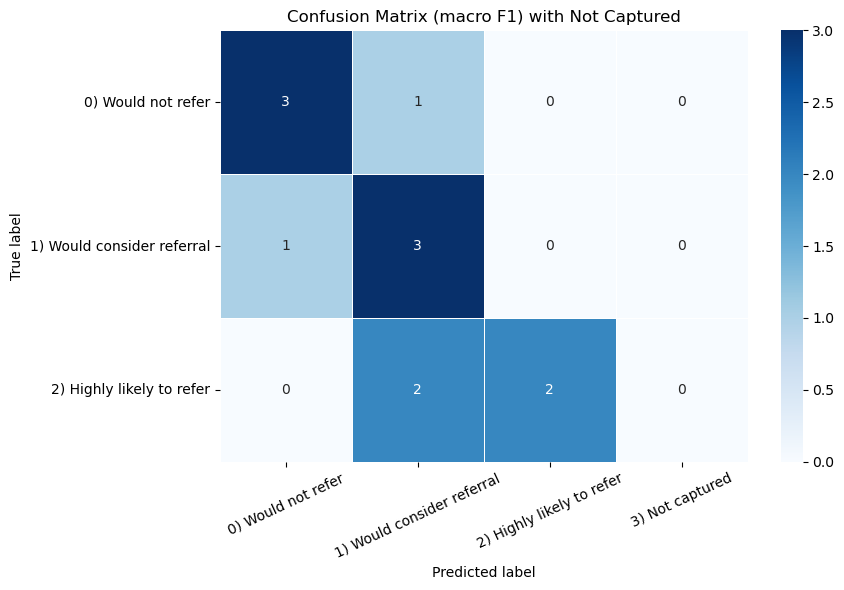

In [13]:
# Extract rows with ground truth labels, tracking which have model predictions
yx_complete = merged_df.loc[~merged_df['label'].isna(), ['score', 'label', 'predicted_label']]
has_prediction = ~yx_complete['score'].isna()

# Extract numeric scores for threshold optimization
yx_numeric = yx_complete.loc[has_prediction, ['score', 'label']]
score_numeric = yx_numeric['score'].values.astype(int)  # model output scores
label = yx_complete['label'].values.astype(int)  # true labels for all rows

# Grid search for optimal threshold cutpoints
# Iterate through all possible cutpoint combinations
results = []
for cut1 in range(1, 100):
    for cut2 in range(cut1 + 1, 101):
        # Create predictions using the current cutpoints
        numeric_preds = np.digitize(score_numeric, bins=[cut1, cut2])  # Maps to (0, 1, 2)
        
        # Create complete predictions array, preserving "Not captured" (3)
        preds = np.full(len(label), 3)  # Default to "Not captured"
        preds[has_prediction.values] = numeric_preds  # Fill in predictions where available
        
        # Calculate metrics using only predictions that aren't "Not captured"
        mask_eval = preds != 3
        macro_f1 = f1_score(label[mask_eval], preds[mask_eval], labels=[0, 1, 2], average="macro")
        
        # Calculate per-class F1 scores
        class_f1 = f1_score(label[mask_eval], preds[mask_eval], labels=[0, 1, 2], average=None)
        f1_0, f1_1, f1_2 = class_f1
        
        results.append({
            "cut1": cut1,
            "cut2": cut2,
            "macro_f1": macro_f1,
            "f1_0": f1_0,
            "f1_1": f1_1,
            "f1_2": f1_2
        })

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Find optimal cutpoints for different objectives
best_macro = results_df.loc[results_df['macro_f1'].idxmax()]  # Best overall F1
best_0 = results_df.loc[results_df['f1_0'].idxmax()]  # Best for "Would not refer" class
best_1 = results_df.loc[results_df['f1_1'].idxmax()]  # Best for "Would consider" class
best_2 = results_df.loc[results_df['f1_2'].idxmax()]  # Best for "Highly likely" class

# Define human-readable labels
cut_labels = [
    "0) Would not refer",
    "1) Would consider referral",
    "2) Highly likely to refer"
]

all_labels = cut_labels + ["3) Not captured"]

# Function to display evaluation results for a specific cutpoint set
# Fixed function to avoid parameter naming confusion
def display_results_with_plot(cut1, cut2, label_name, f1val):
    # Create predictions using the specified cutpoints
    numeric_preds = np.digitize(score_numeric, bins=[cut1, cut2])  # (0, 1, 2)
    
    # Create complete predictions array, preserving "Not captured" (3)
    preds = np.full(len(label), 3)  # Default to "Not captured"
    preds[has_prediction.values] = numeric_preds  # Fill in predictions where available
    
    print(f"\nBest cutpoints for {label_name}: cut1={cut1}, cut2={cut2}, F1={f1val:.4f}")
    
    # Generate classification report (excluding "Not captured")
    mask_eval = preds != 3
    print("Classification Report (excluding 'Not captured'):")
    print(classification_report(
        label[mask_eval], preds[mask_eval], labels=[0, 1, 2],
        target_names=cut_labels
    ))
    
    # Generate full confusion matrix including "Not captured"
    cm = confusion_matrix(label, preds, labels=[0, 1, 2, 3])
    cm = cm[:3, :]  # Only first 3 rows (since y_true only in {0,1,2})
    
    cm_df = pd.DataFrame(cm, index=cut_labels, columns=all_labels)
    print("Confusion Matrix (with 'Not captured'):")
    display(cm_df)

    # Visualize confusion matrix with heatmap
    plt.figure(figsize=(9,6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, square=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix ({label_name}) with Not Captured')
    plt.yticks(rotation=0)
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

# Display results for the optimal macro F1 cutpoint set
display_results_with_plot(int(best_macro.cut1), int(best_macro.cut2), "macro F1", best_macro.macro_f1)

# Optional: Display results for class-specific optimal cutpoints
# display_results_with_plot(int(best_0.cut1), int(best_0.cut2), "score 0 (Would not refer)", best_0.f1_0)
# display_results_with_plot(int(best_1.cut1), int(best_1.cut2), "score 1 (Would consider)", best_1.f1_1)
# display_results_with_plot(int(best_2.cut1), int(best_2.cut2), "score 2 (Highly likely)", best_2.f1_2)